In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

# location to save figures
import os
cwd = os.getcwd()
figure_path = cwd + '/figures/'

# Fitting Functions

In this notebook, I develop fitting functions for EE correlation function

## Halo Catalog

In [2]:
# load a halo catalog
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi',
                            halo_finder='rockstar',
                            redshift=0.0, dz_tol=0.001,
                            version_name='halotools_v0p4')

In [3]:
#halocat = CachedHaloCatalog(simname='bolshoi',
#                            halo_finder='Rockstar',
#                            redshift=0.0, dz_tol=0.001,
#                            version_name='custom')

In [4]:
from intrinsic_alignments.utils.jackknife_observables import jackknife_ed_3d, jackknife_ee_3d

rbins = np.logspace(-1,1.8,25)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

# empirical halo and sub-halo correlations

halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

# define host and sub-halo samples
hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1

# define host halo IDs
host_ids = halocat.halo_table['halo_hostid']

# define halo sub-samples
halo_sample_mask = (halocat.halo_table['halo_mpeak']>10**12.0)

In [5]:
# calculate ED correaltion functions
halo_omega, halo_omega_cov = jackknife_ed_3d(halo_coords[halo_sample_mask], 
                                             halo_orientations[halo_sample_mask],
                                             halo_coords[halo_sample_mask],
                                             rbins, Nsub = [3,3,3],
                                             period=halocat.Lbox, num_threads=4,
                                             verbose=True)
halo_omega_err = np.sqrt(np.diag(halo_omega_cov))

estimated time to complete jackknife calculation (s): 2311.6043179035187


In [6]:
# calculate EE correaltion functions
halo_eta, halo_eta_cov = jackknife_ee_3d(halo_coords[halo_sample_mask], 
                                         halo_orientations[halo_sample_mask],
                                         halo_coords[halo_sample_mask],
                                         halo_orientations[halo_sample_mask],
                                         rbins, Nsub = [4,4,4],
                                         period=halocat.Lbox, num_threads=4,
                                         verbose=True)
halo_eta_err = np.sqrt(np.diag(halo_eta_cov))

estimated time to complete jackknife calculation (s): 3856.0594177246094


In [11]:
r_sample = np.logspace(-1,2,1000)

def f2(r, A=0.01, B=1.0, gamma=1.5):
    """
    2-halo component
    """
    return A/(1.0+(r/B)**gamma)*np.exp(-1.0*B/r)

def f1(r, A=0.55, B=0.18, gamma=0.91):
    """
    1-halo componenet
    """
    return A*np.exp(-1.0*(r/B)**gamma)

def ee_model(r, A1, B1, A2, B2, gamma1, gamma2):
    return f1(r, A1, B1, gamma1) + f2(r, A2, B2, gamma2)

In [12]:
from scipy.optimize import curve_fit

p0 = [0.53453726, 0.17883229, 0.01043898, 2.97565686, 0.87894279, 1.5]
popt, pcov = curve_fit(ee_model, rbin_centers, halo_eta, p0=p0, sigma=halo_eta_err)


In [14]:
r_sample = np.logspace(-1,2,1000)


def f2(r, A1=0.001, B1=10.0, alpha=-2.0, k=1.5, A2=0.2, B2=1.0, B=0.2):
    """
    2-halo component
    """
    return f2_1(r, A1, B1, alpha, k, B) + f2_2(r, A2, B2)

def f2_1(r, A=0.001, B=10.0, alpha=-2.0):
    """
    2-halo component
    """
    return (A*(r/B)**alpha)*np.exp(-1.0*(B/r))

def f2_1(r, A=0.05, B=10.0, alpha=-2.0, beta=1.0):
    """
    2-halo component
    """
    return (A/(1.0+(r/B)**-alpha))*np.exp(-1.0*(B/r)**beta)

def f2_1(r, A=0.01, B=10.0, beta=-2.0, k=1.0, B0=0.2):
    """
    2-halo component
    """
    return broken_powerlaw(r, A=A, x0=B, alpha=0, beta=beta, k=k)*np.exp(-B0/r)

def f2_2(r, A=0.1, B=2.0):
    """
    2-halo component
    """
    return A*1.0/(1+np.exp((r/B)))

def f1(r, A=0.3, B=0.3, gamma=1.6):
    """
    1-halo componenet
    """
    return A*np.exp(-1.0*(r/B)**gamma)

def ed_model(r, A, B, gamma, A1, B1, alpha, k, A2, B2):
    return f1(r, A, B, gamma) + f2(r, A1, B1, alpha, k, A2, B2, B)

In [16]:
def broken_powerlaw(x, A=1.0, x0=1, alpha=0, beta=-4, k=0.1):
    """
    """
    f = _logit(np.log10(x), np.log10(x0), 1/k)
    n = (1-f)*alpha + f*beta
    return A*(x/x0)**n

def _logit(x, x0, k):
    """
    """
    return 1.0/(1.0+np.exp(-k*(x-x0)))

def ed_fit_1(r, A=0.3, B=0.3, gamma=1.6):
    """
    one-halo c-s and s-c fitting function
    """
    return A*np.exp(-1.0*(r/B)**gamma)

def ed_fit_2(r, A=0.1, B=2.0):
    """
    one-halo s-s fitting function
    """
    return A*1.0/(1.0+np.exp((r/B)))

def ed_fit_3(r, A=0.01, B=10.0, beta=-2.0, k=1.0, B0=0.2):
    """
    two-halo fitting function
    """
    return broken_powerlaw(r, A=A, x0=B, alpha=0, beta=beta, k=k)*np.exp(-B0/r)

def ed_fitting_function(r, A, B, gamma, A1, B1, A2, B2, beta, k):
    """
    """
    y1 = ed_fit_1(r, A=A, B=B, gamma=gamma)
    y2 = ed_fit_2(r, A=A1, B=B1)
    y3 = ed_fit_3(r, A=A2, B=B2, beta=beta, k=k, B0=B)
    return y1+y2+y3

from scipy.optimize import curve_fit
p0 = [0.8, 0.18, 0.9,
      0.2, 2.0,
      0.05, 10.0, -2.0, 1.0,]
popt, pcov = curve_fit(ed_fitting_function, rbin_centers, halo_omega, p0=p0, sigma=halo_omega_err)

popt

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

In [17]:
from scipy.optimize import curve_fit

p0 = [0.8, 0.18, 0.9, 0.05, 10.0, -2.0, 1.0, 0.2, 2.0]
popt, pcov = curve_fit(ed_model, rbin_centers, halo_omega, p0=p0, sigma=halo_omega_err)

popt

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

In [18]:
r_sample = np.logspace(-1,2,1000)

def _sigmoid(x, x0=0, k=1, ymin=0, ymax=1):
    """
    sigmoid function
    """
    height_diff = ymax-ymin
    return ymin + height_diff/(1 + np.exp(-k*(x-x0)))

def f2(r, A=0.05, B1=3.0, alpha=-1.0):
    """
    2-halo component
    """
    return A*((r/B1)**alpha)*np.exp(-1.0*B1/r)

def f1(r, A=0.8, B=0.18, gamma=0.9):
    """
    1-halo componenet
    """
    return A*np.exp(-1.0*(r/B)**gamma)

def ed_model(r, A1, B1, gamma, A2, B2_1, alpha):
    return f1(r, A1, B1, gamma) + f2(r, A2, B2_1, alpha)

In [19]:
from scipy.optimize import curve_fit

p0 = [0.53453726, 0.17883229, 0.9, 0.05, 1.0, -0.5]
popt, pcov = curve_fit(ed_model, rbin_centers, halo_omega, p0=p0, sigma=halo_omega_err)

popt

array([ 0.74076865,  0.25070646,  0.71019025,  0.16390801,  2.16674114,
       -1.27127724])

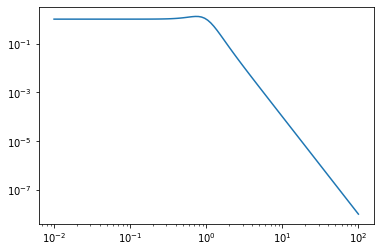

In [20]:
def broken_powerlaw(x, A=1.0, x0=1, alpha=0, beta=-4, k=0.1):
    """
    """
    f = _logit(np.log10(x), np.log10(x0), 1/k)
    n = (1-f)*alpha + f*beta
    return A*(x/x0)**n

def _logit(x, x0, k):
    """
    """
    return 1.0/(1.0+np.exp(-k*(x-x0)))

x = np.logspace(-2,2,100)

plt.figure()
plt.plot(x, broken_powerlaw(x), '-')
plt.xscale('log')
plt.yscale('log')
plt.show()

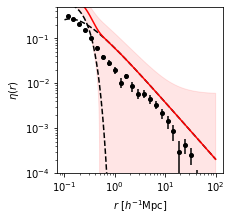

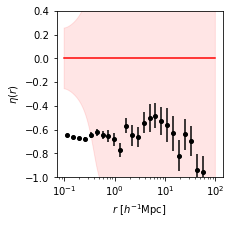

In [21]:
r_sample = np.logspace(-1,2,1000)

fig, ax = plt.subplots(1,1, sharex=True, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, halo_eta, yerr=halo_eta_err,
            fmt='o',  color='black', ms=4)
ax.plot(r_sample, f1(r_sample, popt[0], popt[1], popt[-2]), '--', color='black')
ax.plot(r_sample, f2(r_sample, popt[2], popt[3], popt[-1]), '--', color='black')
ax.plot(r_sample, ee_model(r_sample, *popt), '-', color='red')
result = np.zeros((1000,len(r_sample)))
for i in range(0,1000):
    poptt = np.random.multivariate_normal(popt, pcov)
    result[i,:] = ee_model(r_sample, *poptt)
    #ax.plot(r_sample, result[i,:], '-', color='red', alpha=0.1)
err = np.nanstd(result,axis=0)
ax.fill_between(r_sample, ee_model(r_sample, *popt)+err, ee_model(r_sample, *popt)-err, color='red', alpha=0.1)    
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.0001,0.5])
plt.show()

fig, ax = plt.subplots(1,1, sharex=True, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.plot(r_sample,r_sample*0,'-',color='red')
ax.errorbar(rbin_centers, (halo_eta)/(ee_model(rbin_centers, *popt))-1,
            yerr=halo_eta_err/(ee_model(rbin_centers, *popt)),
            fmt='o',  color='black', ms=4)
for i in range(0,100):
    poptt = np.random.multivariate_normal(popt, pcov)
    #ax.plot(r_sample, ee_model(r_sample, *poptt)/ee_model(r_sample, *popt)-1, '-', color='red', alpha=0.1)
ax.fill_between(r_sample, err/ee_model(r_sample, *popt), -1.0*err/ee_model(r_sample, *popt), color='red', alpha=0.1)    
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([-1,0.4])
plt.show()

TypeError: ed_fitting_function() missing 3 required positional arguments: 'B2', 'beta', and 'k'

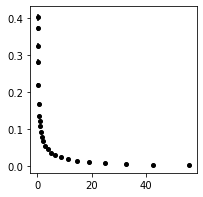

In [22]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.errorbar(rbin_centers, halo_omega, yerr=halo_omega_err,
            fmt='o',  color='black', ms=4)
ax.plot(r_sample, ed_fitting_function(r_sample, *popt), '-', color='red')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([0.001,1])
ax.set_xlim([0.1,100])
plt.show()

fig, ax = plt.subplots(1,1, sharex=True, figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.plot(r_sample,r_sample*0,'-',color='red')
ax.errorbar(rbin_centers, (halo_omega)/(ed_fitting_function(rbin_centers, *popt))-1,
            yerr=halo_omega_err/(ed_fitting_function(rbin_centers, *popt)),
            fmt='o',  color='black', ms=4)
ax.set_xscale('log')
ax.set_xlabel(r'$r~[h^{-1}\rm Mpc]$')
ax.set_ylabel(r'$\eta(r)$')
ax.set_ylim([-0.5,0.1])
plt.show()